In [2]:
import os, sys
if 'google.colab' in sys.modules:
    %cd /content
    if not os.path.isdir('MPyDATA'):
        !git clone --depth 1 https://github.com/atmos-cloud-sim-uj/MPyDATA.git
    %cd MPyDATA
    !pip install -r requirements.txt

In [3]:
import os, sys
if 'google.colab' in sys.modules:
    %cd /content/MPyDATA/MPyDATA_examples/Williamson_and_Rasch_1989_as_in_Jaruga_et_al_2015_Fig_14
sys.path.insert(0, os.path.join(os.getcwd(), '../..'))

In [4]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import matplotlib
from MPyDATA import VectorField, ScalarField
from MPyDATA import Options
from MPyDATA.arakawa_c.discretisation import from_pdf_2d
from MPyDATA import PeriodicBoundaryCondition, PolarBoundaryCondition
from MPyDATA import Stepper, Solver

In [5]:
options = Options(n_iters=2, flux_corrected_transport=True)

In [6]:
nlon = 129
nlat = 64
nt = 100 # TODO: 5120
dlmb = 2 * np.pi / (nlon-1)
dphi = np.pi / nlat

r = 7 * dlmb
x0 = 3 * np.pi / 2
y0 = 0

udt = 2 * np.pi / nt
b = -np.pi / 2
h0 = 1

In [7]:
boundary_conditions = (PeriodicBoundaryCondition(), PolarBoundaryCondition((nlon, nlat), 0, 1))

In [8]:
@numba.njit()
def pdf(x, y):
    tmp = 2*(
        (np.cos(dphi * (y + 0.5) - np.pi / 2) * np.sin((dlmb * x - x0) / 2))**2 +
        np.sin((dphi * (y + 0.5) - np.pi / 2 - y0) / 2)**2
    )
    return h0 + np.where(
        # if
        tmp - r**2 <= 0,
        # then
        1 - np.sqrt(tmp)/r,
        # else
        0.
    )

In [9]:
x, y, z = from_pdf_2d(pdf, xrange=(0, nlon), yrange=(0, nlat), gridsize=(nlon, nlat))
# yrange is (0, nlat) because in pdf we subtract pi/2, so domain is (-pi/2, pi/2)

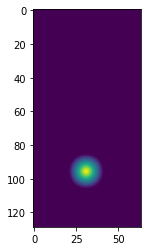

In [10]:
plt.imshow(z)

In [11]:
def ad_x(i, j):
    return dlmb * udt * (
        np.cos(b) * np.cos((j+0.5) * dphi - np.pi / 2) + 
        np.sin(b) * np.sin((j+0.5) * dphi - np.pi / 2) * np.cos((i+0.5) * dlmb)
    )


In [12]:
def ad_y(i, j):
    return -dlmb * udt * np.sin(b) * np.sin((i) * dlmb)* np.cos((j+1) * dphi - np.pi / 2)

In [13]:
advector_x = np.array([[
    ad_x(i, j)
    for i in range(nlat)] for j in range(nlon+1)])

advector_y = np.array([[
    ad_y(i,j)
    for i in range(nlat+1)] for j in range(nlon)])

(130, 64)


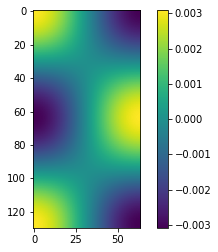

In [14]:
plt.imshow(advector_x)
plt.colorbar()
print(advector_x.shape)

(129, 65)


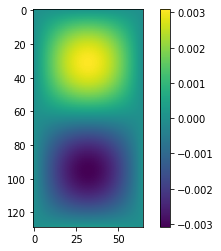

In [15]:
plt.imshow(advector_y)
plt.colorbar()
print(advector_y.shape)

In [16]:
@numba.njit()
def pdf_g_factor(x, y):
    return dlmb * dphi * np.cos(dphi * (y + 0.5) - np.pi / 2)
x, y, g_factor_z = from_pdf_2d(pdf_g_factor, xrange=(0, nlon), yrange=(0, nlat), gridsize=(nlon, nlat))

(129, 64)


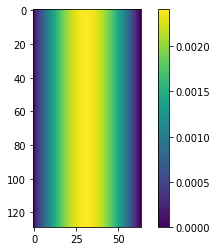

In [17]:
plt.imshow(g_factor_z)
plt.colorbar()
print(g_factor_z.shape)

In [18]:
g_factor = ScalarField(
    data=g_factor_z, 
    halo=options.n_halo, 
    boundary_conditions=boundary_conditions
)

In [19]:
@numba.njit()
def pdf_g_factor(x, y):
    return dlmb * dphi * np.cos(dphi * (y + 0.5) - np.pi / 2)

In [20]:
x, y, z = from_pdf_2d(pdf, xrange=(0, nlon), yrange=(0, nlat), gridsize=(nlon, nlat))
advector = VectorField(
    data=(advector_x, advector_y),
    halo=options.n_halo,
    boundary_conditions=boundary_conditions    
)
advectee = ScalarField(
    data=z, 
    halo=options.n_halo, 
    boundary_conditions=boundary_conditions
)

In [21]:
stepper = Stepper(options=options, n_dims=2, non_unit_g_factor=True)

In [22]:
solver = Solver(stepper=stepper, advectee=advectee, advector=advector, g_factor=g_factor)

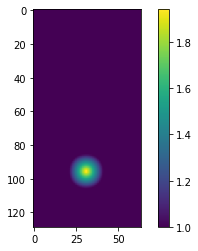

In [23]:
plt.imshow(solver.advectee.get())
plt.colorbar()

In [24]:
states_history = [z]
for i in range(15):
    solver.advance(nt=1)
    states_history.append(solver.advectee.get().copy())    

# Plots 

In [25]:
from matplotlib import cm
import matplotlib.animation as animation

theta = np.linspace(0, np.pi,   nlat, endpoint=True)
phi   = np.linspace(0, np.pi*2, nlon, endpoint=True)

X = np.outer(np.sin(theta), np.cos(phi))
Y = np.outer(np.sin(theta), np.sin(phi))
Z = np.outer(np.cos(theta), np.ones(nlon))

def plot_state(state, save_path=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_axis_off()
    norm = matplotlib.colors.Normalize(vmin=h0, vmax=h0+1)
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                    facecolors=cm.plasma(norm(state.transpose())), alpha=0.25, linewidth=1)
    m = cm.ScalarMappable(cmap=cm.plasma, norm=norm)
    m.set_array([])
    plt.colorbar(m)
    if save_path:
        plt.savefig(save_path)
    return plt.show()

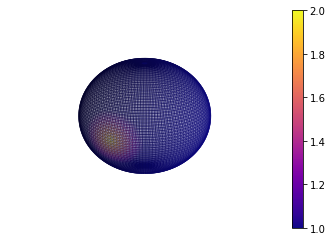

1.0 1.9400811538791944


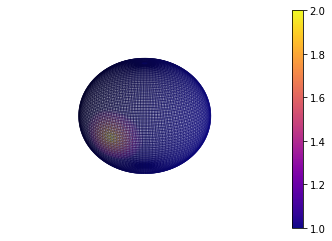

-209.31968110702422 529157657427.8315


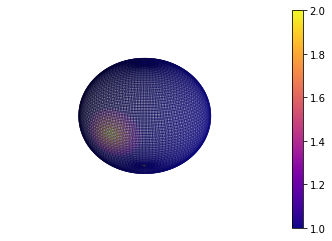

-6.327935753988741e+32 6.32793575398874e+32


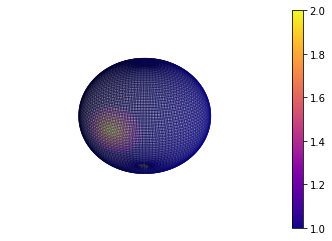

-8.200556011528e+56 7.233133447951935e+56


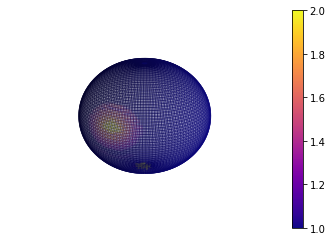

-2.3875623081890695e+80 2.38756230818907e+80


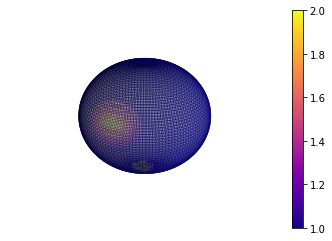

-2.4776328165547013e+96 4.868973082101531e+96


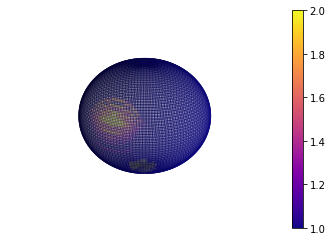

-7.313340213414095e+112 7.248107447030451e+112


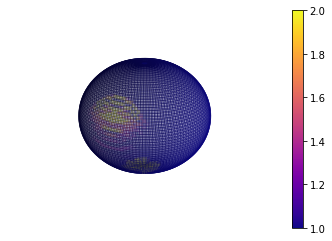

-6.087556145060257e+129 6.087556145057311e+129


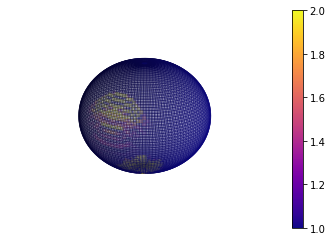

-4.60453624567977e+152 4.60453624567977e+152


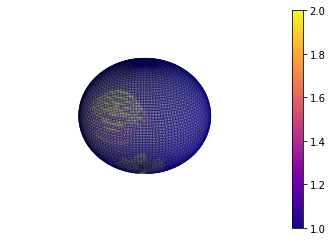

-4.78545426657862e+177 4.7854542665729415e+177


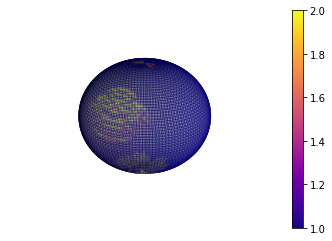

-2.761466287589341e+193 4.671518490542601e+193


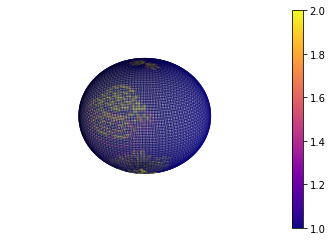

-7.142952705971817e+215 7.142952705971819e+215


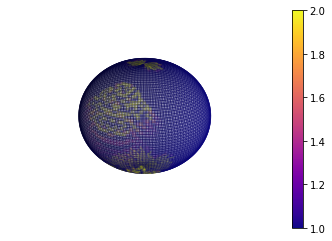

-6.265520754348774e+231 6.382413864412879e+231


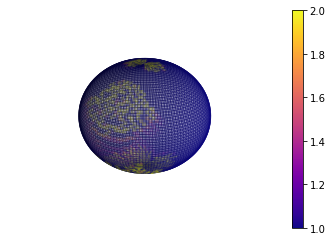

-1.785809498654612e+256 1.7858094986686824e+256


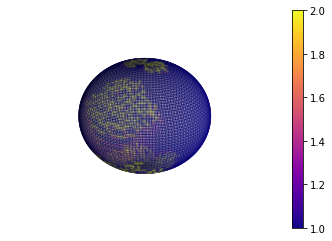

-1.4781465454758921e+277 1.4781465454758994e+277


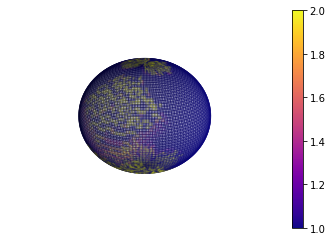

-1.8838148791620948e+297 1.883814873004916e+297


In [29]:
!rm -rf animation
!mkdir animation
paths = []
for i, state in enumerate(states_history):
    path = 'animation/{}.png'.format(i)
    paths.append(path)
    plot_state(state, path)
    print(np.amin(state), np.amax(state))

In [27]:
import os
os.system("ffmpeg -f image2 -r 10 -i ./animation/%01d.png -vcodec mpeg4 -y simulation.mp4")

0

In [28]:
from IPython.display import Video
Video("simulation.mp4")